# Predicting Heart Disease

This project will predict the liklihood of a new patient having heart disease in the future.

Import the basic data science and model packages for classification and interpretation:

In [35]:
# import libraries
import pandas as pd
import lightgbm as lgb

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import shap # SHAP for model interpretation
shap.initjs() # Initialize SHAP JavaScript visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Exploratory Data Analysis (EDA)


Load the dataset. We are using a World Health Organisation heart disease prediction dataset.

In [36]:
# Load the dataset
df = pd.read_csv("heart_disease_prediction.csv")

# display the first few rows of the dataset
print("First few rows of the dataset:\n", df.head())



First few rows of the dataset:
    Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


## Data Overview

Check the structure, types, missing values and basic stats about the dataset.

In [37]:
# shape of data
print("Shape of the dataset:", df.shape)

# print column names
print("Column names in the dataset:", df.columns)

# print data types of each column
print("Data types of each column:\n", df.dtypes)

# count the number of each data type
print("Count of each data type:\n", df.dtypes.value_counts())

Shape of the dataset: (918, 12)
Column names in the dataset: Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')
Data types of each column:
 Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object
Count of each data type:
 int64      6
object     5
float64    1
Name: count, dtype: int64


There are 12 features. 7 are numerical and 5 are categorical. However, HeartDisease and FastingBS are binary (0 or 1).

# Descriptive Statistics

1. What is the average age of the patients? 

- The mean age is 53.5

2. Are there any features that have statistics that don't look right to you or that stand out? Maybe a very high or low value for a given statistic?

- Cholesterol and blood sugar values of 0
- Heart disease has an integer value between 0 and 1 when it can only be either 0 or 1.

3. Are there any missing values?

- there are values in all cells

In [38]:
# Descriptive statistics
print("Descriptive statistics of the dataset:\n", df.describe())

# Check for missing values
print("Missing values in each column:\n", df.isnull().sum())

Descriptive statistics of the dataset:
               Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000  
Missing values in each 

In [39]:
# Which elements are categorical?
categorical_columns = df.select_dtypes(include=['object']).columns
print("Categorical columns in the dataset:", categorical_columns)
df.describe(include=['object'])

Categorical columns in the dataset: Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


The unique counts show that the variables ChestPainType, RestingECG, ExerciseAngina and ST_Slope are categorical variables.

In [40]:
# What are the unique values in the categorical columns?
print("Unique values in categorical columns:")

df["FastingBS"].unique(), df["HeartDisease"].unique() 

Unique values in categorical columns:


(array([0, 1]), array([0, 1]))

# Visualise categorical variables

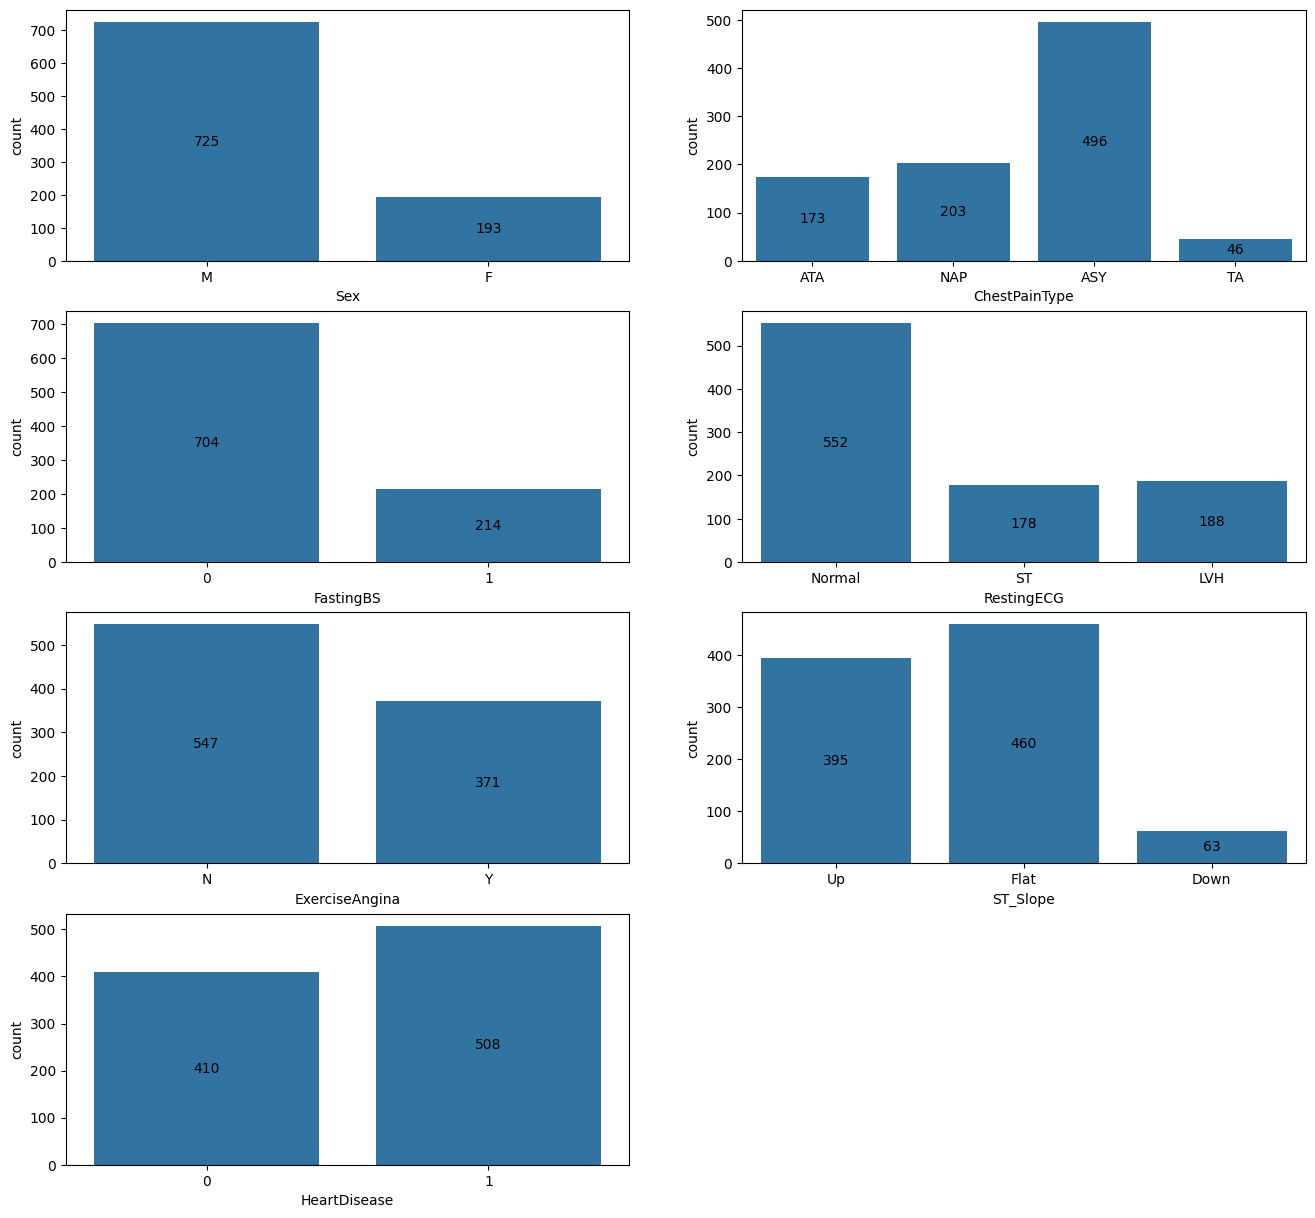

In [41]:
categorical_cols = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease"]

fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols):
    ax = plt.subplot(4, 2, idx+1)
    sns.countplot(x=df[col], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

# Interpration of visuals

1. there are almost 4 times as many male patients as female
2. most patients are asymptomatic.
3. most patients did not fast
4. 547 patients do not have exercise induced angina
5. 552 patient had a normal resting ECG
6. 508 patients have heart disease

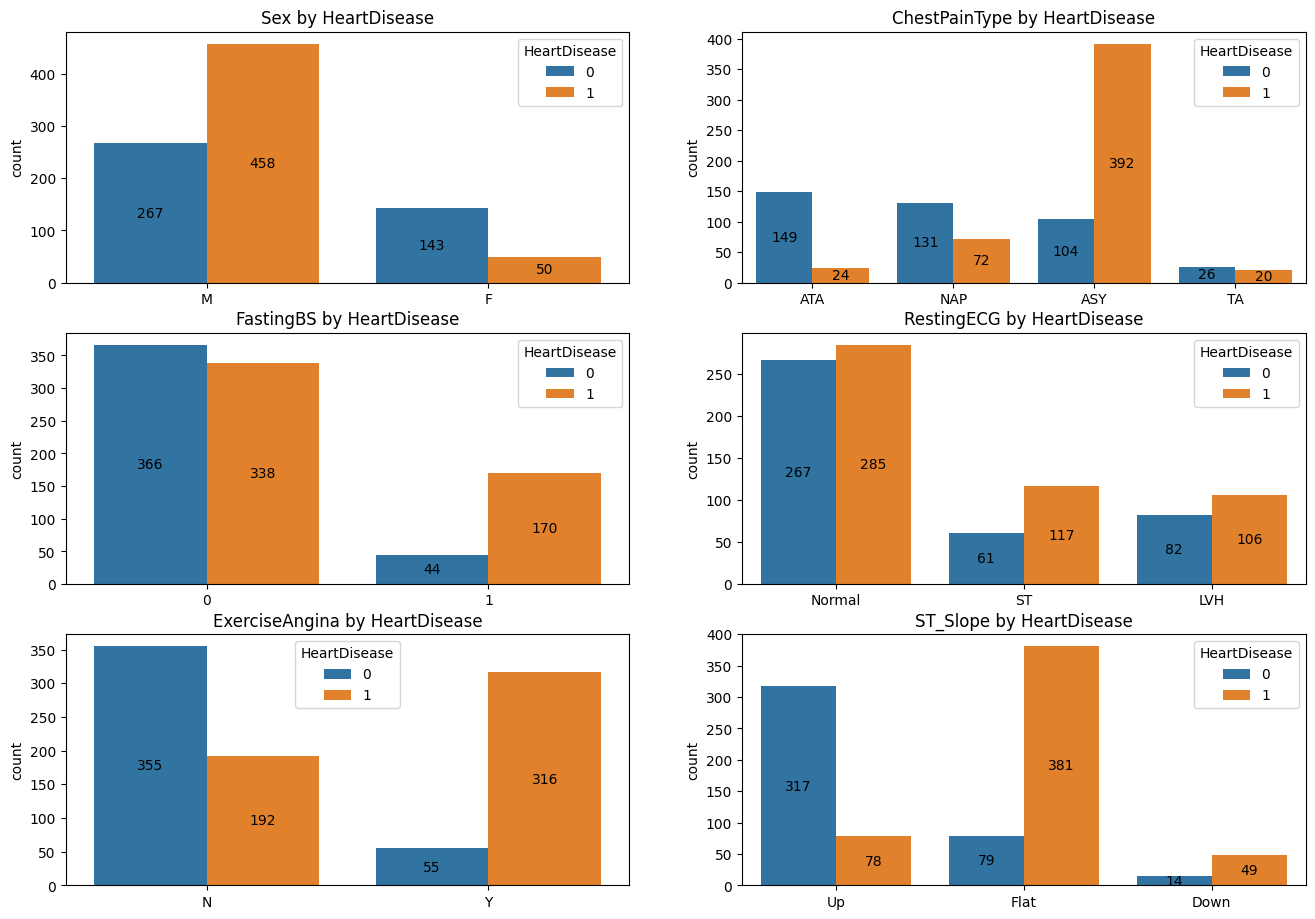

In [42]:
# group by each of the cateogrical variables by HeartDisease and visualise the results in a countplot
categorical_cols = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"]

fig = plt.figure(figsize=(16, 15))

for idx, col in enumerate(categorical_cols):
    ax = plt.subplot(4, 2, idx + 1)
    sns.countplot(x=df[col], hue=df["HeartDisease"], ax=ax)
    ax.set_title(f"{col} by HeartDisease")
    # no x axis label
    ax.set_xlabel("")

    # Add bar labels
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

In [43]:
# What is the median age of patients with and without heart disease?
print("Median age of patients with heart disease:", df[df["HeartDisease"] == 1]["Age"].median())
print("Median age of patients without heart disease:", df[df["HeartDisease"] == 0]["Age"].median())

Median age of patients with heart disease: 57.0
Median age of patients without heart disease: 51.0


Percentage of male patients over 50: 67.17%


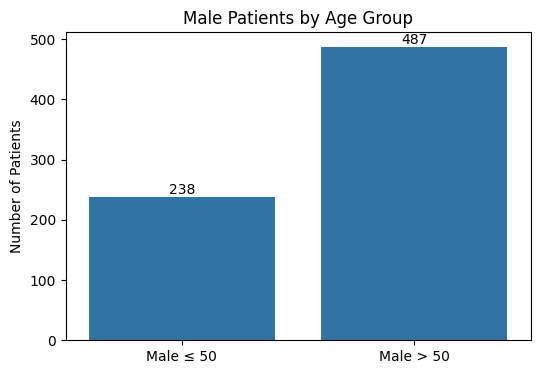

In [44]:
# Calculate percentage of male patients over 50
male_patients = df[df['Sex'] == 'M']
over_50_male = male_patients[male_patients['Age'] > 50]
percentage_over_50 = (len(over_50_male) / len(male_patients)) * 100

print(f"Percentage of male patients over 50: {percentage_over_50:.2f}%")

# Plot the result
labels = ['Male ≤ 50', 'Male > 50']
counts = [len(male_patients) - len(over_50_male), len(over_50_male)]

plt.figure(figsize=(6,4))
sns.barplot(x=labels, y=counts)
plt.ylabel('Number of Patients')
plt.title('Male Patients by Age Group')
for i, count in enumerate(counts):
    plt.text(i, count + 5, f"{count}", ha='center')
plt.show()

# Cleaning up the data

In [45]:
# How many rows have a zero value for the column "RestingBP"?
zero_restingbp_count = df[df["RestingBP"] == 0].shape[0]
print("Number of rows with zero value for 'RestingBP':", zero_restingbp_count)

# how many rows have a zero value for the column "Cholesterol"?
zero_cholesterol_count = df[df["Cholesterol"] == 0].shape[0]
print("Number of rows with zero value for 'Cholesterol':", zero_cholesterol_count)

Number of rows with zero value for 'RestingBP': 1
Number of rows with zero value for 'Cholesterol': 172


In [46]:
# group the data by HeartDisease and calculate the mean of RestingBP, and of Cholesterol
bp_chol_by_heartdisease = df[["HeartDisease","RestingBP","Cholesterol"]].groupby("HeartDisease").median().reset_index()
bp_chol_by_heartdisease

,HeartDisease,RestingBP,Cholesterol
0,0,130.0,227.0
1,1,132.0,217.0


Replace 0 values in RestingBP and Cholesterol with their respective median values, depending on whether HeartDisease is present or not (1 or 0 respectively). 

In [47]:
# Copy the original DataFrame to avoid modifying it directly
df_clean = df.copy()

# Replace 0s in RestingBP with the mean from the opposite HeartDisease group
df_clean.loc[(df_clean["HeartDisease"] == 0) & (df_clean["RestingBP"] == 0), "RestingBP"] = bp_chol_by_heartdisease.loc[1, "RestingBP"]
df_clean.loc[(df_clean["HeartDisease"] == 1) & (df_clean["RestingBP"] == 0), "RestingBP"] = bp_chol_by_heartdisease.loc[0, "RestingBP"]

# Replace 0s in Cholesterol with the mean from the opposite HeartDisease group
df_clean.loc[(df_clean["HeartDisease"] == 0) & (df_clean["Cholesterol"] == 0), "Cholesterol"] = bp_chol_by_heartdisease.loc[1, "Cholesterol"]
df_clean.loc[(df_clean["HeartDisease"] == 1) & (df_clean["Cholesterol"] == 0), "Cholesterol"] = bp_chol_by_heartdisease.loc[0, "Cholesterol"]

# Display the first rows of the cleaned DataFrame
df_clean.head()

# Display the descriptive statistics of the cleaned DataFrame for RestingBP and Cholesterol

df_clean[["Cholesterol", "RestingBP"]].describe()

,Cholesterol,RestingBP
count,918.000000,918.000000
mean,241.113290,132.538126
std,53.838668,17.990127
min,85.000000,80.000000
25%,214.000000,120.000000
50%,227.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000


# Feature Selection

In preparation for classification, the categorical variables need to be encoded as 1s and 0s. One-hot encoding (pd.get_dummies) will be used.

In [48]:
# Convert categorical variables to dummy variables. True is 1 and False is 0.
df_clean = pd.get_dummies(df_clean, drop_first=True).astype(int)
df_clean.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0,0,1,0,1,0,1,0,0,0,1


## How do the variables relate to each other?

A pearson correlation matrix shows whether variables are linearly correlated, from -1 to 1.

Correlation matrix:
                         Age  RestingBP  Cholesterol  FastingBS     MaxHR  \
Age                1.000000   0.263054     0.033185   0.198039  0.382045   
RestingBP          0.263054   1.000000     0.089909   0.067896  0.109771   
Cholesterol        0.033185   0.089909     1.000000   0.003053  0.019705   
FastingBS          0.198039   0.067896     0.003053   1.000000  0.131438   
MaxHR              0.382045   0.109771     0.019705   0.131438  1.000000   
Oldpeak            0.222111   0.165555     0.052084   0.041421  0.165156   
HeartDisease       0.282039   0.117798     0.056865   0.267291  0.400421   
Sex_M              0.055750   0.009346     0.124360   0.120076  0.189186   
ChestPainType_ATA  0.218165   0.051293     0.007941   0.140514  0.253735   
ChestPainType_NAP  0.011335   0.027772     0.059902   0.039249  0.134580   
ChestPainType_TA   0.032042   0.049498     0.040012   0.026885  0.100025   
RestingECG_Normal  0.230566   0.113842     0.043766   0.093028  0.0

<Axes: >

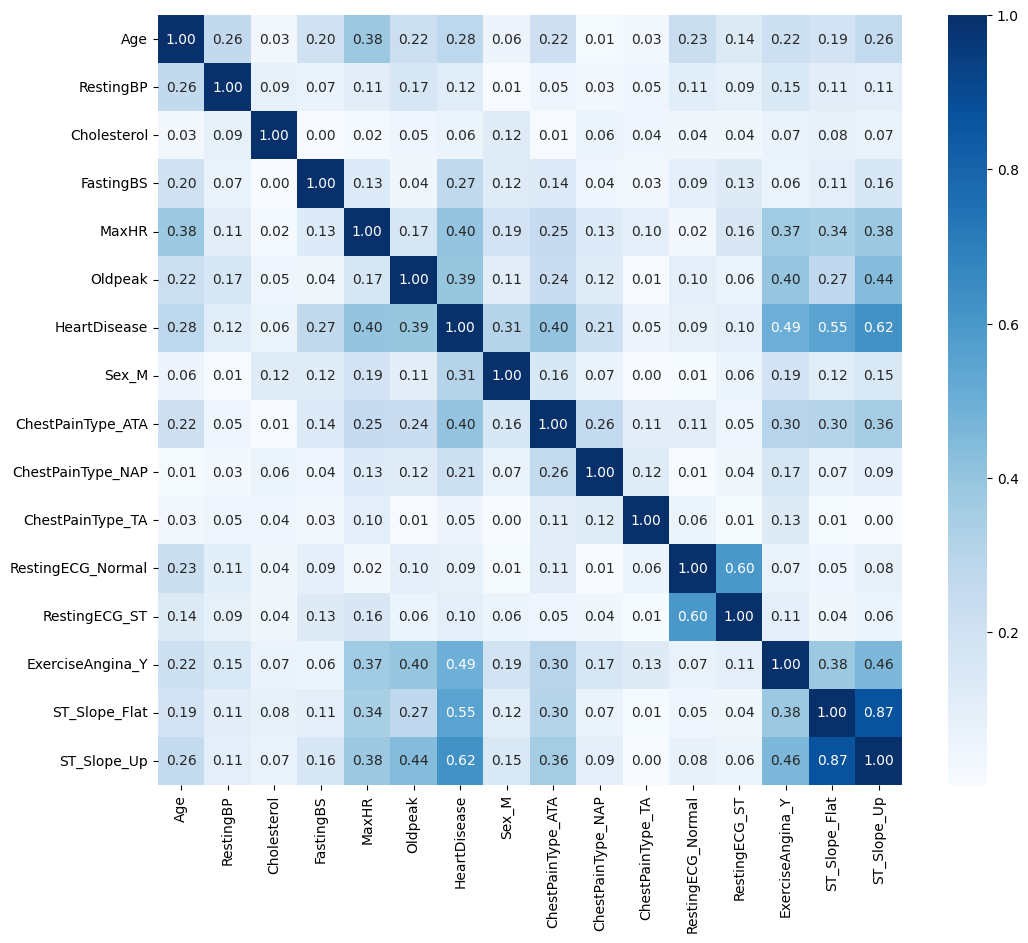

In [49]:
df_clean_corr = abs(df_clean.corr()) # absolute value of the correlation matrix
print("Correlation matrix:\n", df_clean_corr)
plt.figure(figsize=(12, 10))
sns.heatmap(df_clean_corr, annot=True, fmt=".2f", cmap="Blues")

<Axes: >

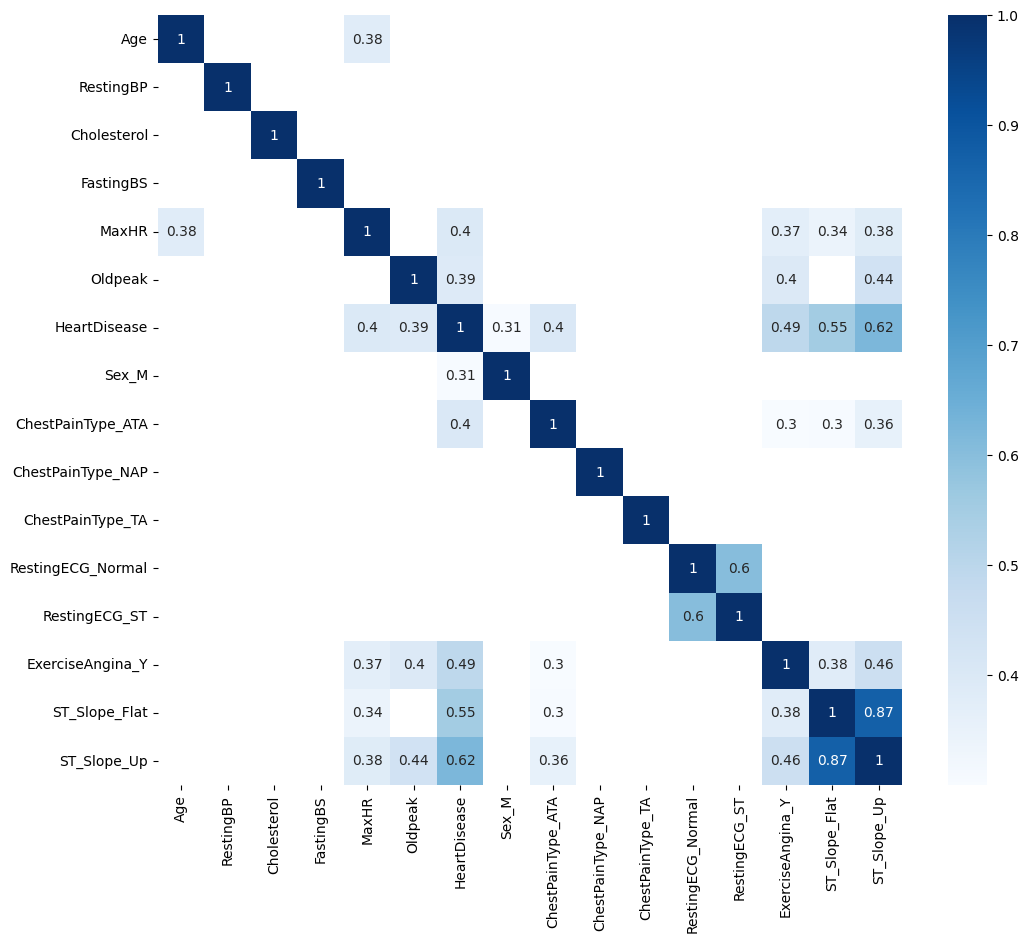

In [50]:
# Create a mask for the heatmap to show only correlations with a magnitude greater than 0.3
mask = (df_clean_corr > 0.3) 
plt.figure(figsize=(12, 10))
sns.heatmap(df_clean_corr[mask], annot=True, cmap="Blues")


According to the heatmap, the following features are related to HeartDisease (correlation > abs(0.3))

Positive correlation:
- ST_Slope_Flat
- ExerciseAngina_Y
- Sex_M
- OldPeak

Negative correlation:
-ST_Slope_Up
- ChestPain_ATA
- MaxHR

# Building a Classifier: k-NN

k-NN: k-nearest neighbours - supervised ML algorithm for classification. It is for pattern regnition  - it classified objects based on similarity. It is non-parameteric which means it makes no assumptions about the underlying data distribution. It is also simple and interpretable. 


## Train/Test Split

In [51]:
# Split the data into features (X) and target variable (y)
X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

# Split the data into training and validation sets. 15% of the data is used for validation.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state = 417)



In [52]:
# list of features to be used for classification
features = [
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

# check the accuracy of k-NN classifier for each feature
print("Checking accuracy of k-NN classifier for each feature:")
for feature in features:
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_val[[feature]], y_val)
    print(f"The k-NN classifier trained on {feature} and with k = 3 has an accuracy of {accuracy*100:.2f}%")

Checking accuracy of k-NN classifier for each feature:
The k-NN classifier trained on Oldpeak and with k = 3 has an accuracy of 65.94%
The k-NN classifier trained on Sex_M and with k = 3 has an accuracy of 47.83%
The k-NN classifier trained on ExerciseAngina_Y and with k = 3 has an accuracy of 71.74%
The k-NN classifier trained on ST_Slope_Flat and with k = 3 has an accuracy of 79.71%
The k-NN classifier trained on ST_Slope_Up and with k = 3 has an accuracy of 82.61%


The model is most accurate for the ST_Slope_Up with k=3 (82.61%), followed by ST_SLope_Flat then Exercise_Angina_Y. 
The model accuracy does not improve past k=3.
The model has lowest accuracy for Sex_M (47.83%)

# Building a classifier with multiple features

For k-NN, scaling is required to normalise the features because this classification apporach is sensitive to distances. `MaxMinScaler` is used. LightGBM wil later be used for classification, but normalisation is not needed.


In [53]:
# Scale the features using MinMaxScaler for k-NN
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])

In [54]:
# Train a k-NN classifier with the scaled features

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_val_scaled, y_val)
print(f"Accuracy: {accuracy*100:.2f} %")

Accuracy: 85.51 %


The classifier is accurate to 85.51%. This is a marginal improvement. Which paramters are optimal?

# Hyperparameter Optimisation

In [55]:
# Prepare the data for hyperparameter tuning
# Split the data into features (X) and target variable (y)

X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 417)

features = [
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])

In [56]:
# I will use minkowski (default in skit-learn) and manhattan distance for the hyperparameter optimisation with k between 1 and 20.
    
grid_params = {"n_neighbors": range(1, 20),
                "metric": ["minkowski", "manhattan"]
              }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)

,estimator,KNeighborsClassifier()
,param_grid,"{'metric': ['minkowski', 'manhattan'], 'n_neighbors': range(1, 20)}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,9


In [57]:
print(f"The best model has an accuracy of {round(knn_grid.best_score_*100,2)} % , with {knn_grid.best_params_['n_neighbors']} neighbours and using the metric {knn_grid.best_params_['metric']}")

The best model has an accuracy of 84.74 % , with 9 neighbours and using the metric minkowski


In [58]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score

# Fit your model (e.g., k-NN or LightGBM)

knn_grid.fit(X_train, y_train)

# Evaluate baseline
baseline = accuracy_score(y_test, knn_grid.predict(X_test))

# Get permutation importance
result = permutation_importance(knn_grid, X_test, y_test, n_repeats=10, random_state=42)

# Show sorted importance
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': result.importances_mean
}).sort_values(by='importance', ascending=False)

print(importance_df)


              feature  importance
4               MaxHR    0.044203
2         Cholesterol    0.031159
13      ST_Slope_Flat    0.010145
14        ST_Slope_Up    0.009420
7   ChestPainType_ATA    0.008696
1           RestingBP    0.007246
0                 Age    0.007246
3           FastingBS    0.006522
11      RestingECG_ST    0.006522
12   ExerciseAngina_Y    0.005797
10  RestingECG_Normal    0.001449
9    ChestPainType_TA    0.000000
5             Oldpeak   -0.000725
6               Sex_M   -0.007246
8   ChestPainType_NAP   -0.010145


Since the **GridSearchCV** uses cross-validation, it is most likely more accurate that the previous attempt.

In [59]:
# Model Evaluation on Test Data

# Refit GridSearchCV on only the selected features
knn_grid.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test[features])
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f" Model Accuracy on test set: {accuracy*100:.2f}")

# The test data classifier has a lower accuracy than the training data classifer (84.06% vs 85.51%), which is expected due to overfitting.

 Model Accuracy on test set: 84.06


## Proportion of males in overall, training and test datasets

In [60]:
print("Distribution of patients by their sex in the entire dataset")
print(X.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the training dataset")
print(X_train.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the test dataset")
print(X_test.Sex_M.value_counts())

Distribution of patients by their sex in the entire dataset
Sex_M
1    725
0    193
Name: count, dtype: int64

Distribution of patients by their sex in the training dataset
Sex_M
1    619
0    161
Name: count, dtype: int64

Distribution of patients by their sex in the test dataset
Sex_M
1    106
0     32
Name: count, dtype: int64


In [61]:
overall_males_pc = 715/(715+193)
print(f"The proportion of males in the overall dataset is {overall_males_pc:.2f} %")
training_males_pc = 619/(619+161)
print(f"The proportion of males in the training dataset is {training_males_pc:.2f} %")
test_males_pc = 106/(106+32)
print(f"The proportion of males in the training dataset is {test_males_pc:.2f} %")

The proportion of males in the overall dataset is 0.79 %
The proportion of males in the training dataset is 0.79 %
The proportion of males in the training dataset is 0.77 %


The share of males in the datasets is much higher than females, skewing the results.

The proportion of males between datasets is not much different (77-79%).

# Alternative to k-NN Classifier: LightGMB Classifier

In [62]:
# Example: Load CSV and split features and target
df = pd.read_csv("heart_disease_prediction.csv")

X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

# Convert object columns to 'category' dtype
cat_features = X.select_dtypes(include=["object"]).columns.tolist()
X[cat_features] = X[cat_features].astype("category")

# Now split (after type conversion)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = lgb.LGBMClassifier()
model.fit(X_train, y_train, categorical_feature=cat_features)

[LightGBM] [Info] Number of positive: 401, number of negative: 333
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 363
[LightGBM] [Info] Number of data points in the train set: 734, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546322 -> initscore=0.185819
[LightGBM] [Info] Start training from score 0.185819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [63]:
# make predictions

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}") # 0.88


Accuracy: 0.88


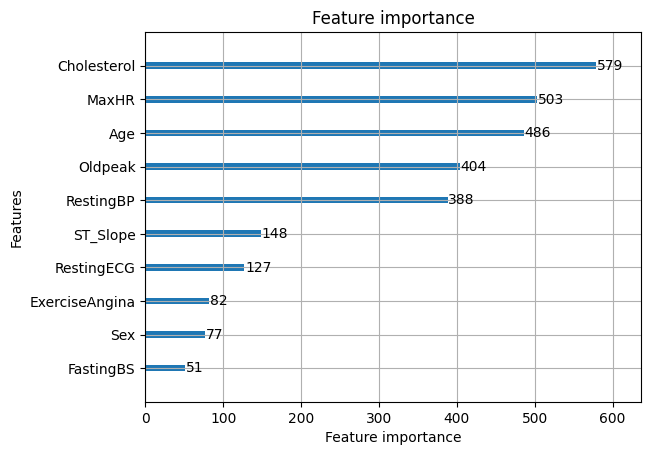

In [64]:
# Feature importance
import matplotlib.pyplot as plt
lgb.plot_importance(model, max_num_features=10)
plt.show()


# Permutation Importance to compare k-NN and LightGBM

Permuation importance randomly shuffles one feature at a time and checks how much the model’s accuracy drops. The bigger the drop, the more important the feature. It is model agnostic.



In [65]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score

# Fit your model (e.g., k-NN or LightGBM)
model.fit(X_train, y_train)

# Evaluate baseline
baseline = accuracy_score(y_test, model.predict(X_test))

# Get permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Show sorted importance
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': result.importances_mean
}).sort_values(by='importance', ascending=False)

print(importance_df)


[LightGBM] [Info] Number of positive: 401, number of negative: 333
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 363
[LightGBM] [Info] Number of data points in the train set: 734, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546322 -> initscore=0.185819
[LightGBM] [Info] Start training from score 0.185819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

**What is the difference between lgb-plot_importance() and permutation_importance()?**

plot_importance is an internal model metric like gain or split count (split by default) and it comes from LightGBM's trees, whereas permutation_importance measures the actual drop in performance when a feature is shuffled and it comes from klearn inspection on the test set.

log-plot-importance() measures how often a feature is used to split the data across all trees. If, instead of split, gain is slected as the type, it measures how much each split reduces error. It relfects training-time usage, not predictive value on new data.

permutation_importance() measures how much worse the mdoel performa when a feature is destroyed (shuffled) on the test set. It captures real-world predictive contribution. It is sensitive to feature interactions, overfitting and test set distribution.

Illustrative example: RestingBP might be used a lot in early tree splits (high LighGBM importance) but may not improve test accuracy when peruted (low or zero permutation importance)

Permutation importance is good for model explainability for end users and for guiding feature selection to improve model performance.


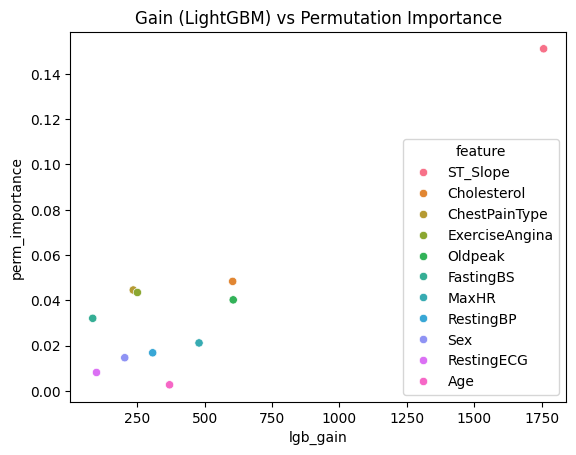

In [66]:
import seaborn as sns

# LightGBM internal importance
lgb_imp = pd.DataFrame({
    'feature': model.feature_name_,
    'lgb_gain': model.booster_.feature_importance(importance_type='gain')
})

# Your permutation importance results
perm_imp = pd.DataFrame({
    'feature': X_test.columns,
    'perm_importance': result.importances_mean
})

# Merge and compare
merged = lgb_imp.merge(perm_imp, on='feature')
merged.sort_values('perm_importance', ascending=False, inplace=True)

sns.scatterplot(data=merged, x='lgb_gain', y='perm_importance', hue='feature')
plt.title("Gain (LightGBM) vs Permutation Importance")
plt.show()


## Shap for LightGBM Model

SHAP (Shapely Additive Explanations) explains how each feature contributes to a specific prediction, based on game theory.

It works best on tree-based models such as LightGMB but it is much slower and less supported for other models like k-NN, but for which KernelSHAP can be used.

Note for programming purposes: the shap library requires numpy 2.2 or lower.

c:\Users\danie\Documents\heart_disease_prediction\.venv\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


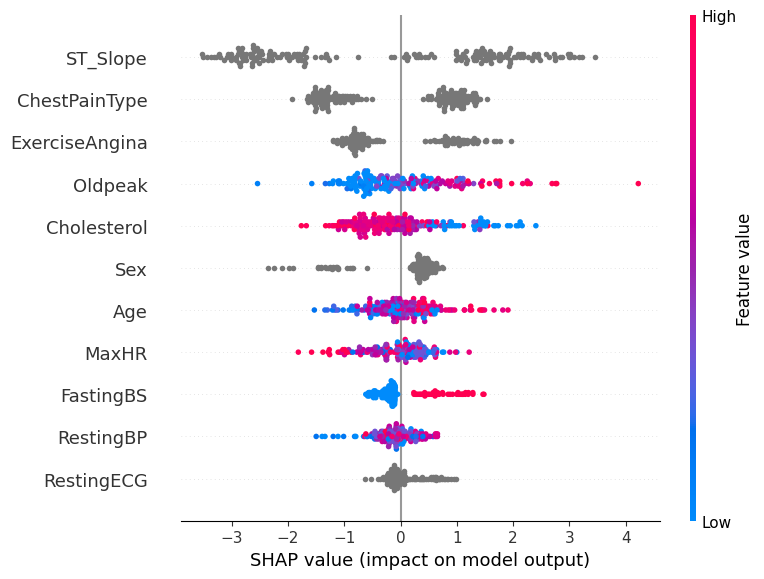

In [67]:

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

# Force plot for a single prediction
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])



### Interpretation of SHAP plot (on LightGBM model)

Overall interpretation of Beeswarm Summary Plot:

- ST_Slope, ChestPainType, and ExerciseAngina are the most influential features overall.
- Each dot = one patient.
- Red = high feature value, blue = low feature value.
- X-axis = SHAP value (positive = push toward “heart disease”, negative = push toward “no heart disease”).


Heart disease risk is increased by:
- high exercise angine 
- more depression (Oldpeak)
- low MaxHR

Heart disease risk is lowered by:
- low age

Some features show mixed effect on heart disease risk. These are:
- Cholesterol: could mean that thresholds matter
- ST_Slope shows complex interactions, likely dependent on other features

#### Interpretation fo SHAP Force Plot (Single Prediction)

Patient input:
Age: 63 (high)
ST_Slope = Up
ChestPainType = ATA
ExerciseAngina = No
Sex = Female
MaxHR = 179 (very high)
Oldpeak = 0
FastingBS = 0

Age pushes the patient towards heart disease but all other factors are blue i.e. push toward no heart disase. The patient had no agina, normal ST slope, high MaxHR and no concerning ECG or blood sugar markers. The final prediction f(x)=-3.87 is a very low base valid, so a very low predicted risk.

# Conclusions
1. The k-NN classifier results in a ~85% accuracy - it successfully explains that share of cases.
2. The rate of heart disease can be explained best to a ~84% accuracy by the parameters Oldpeak, Sex_M, ExerciseAngina_Y, ST_Slope_Flat and ST_Slope_Up.
3. The sex of participants is over 75% male, which may skew the results.

Using LightGBM, the picture changes.
1. This model is 88% accurate.

Unlike k-NN, LightGBM builds trees so that it can naturally capture feature interactions. For example, being male and having high cholesterol may be key combination. k_NN also does not have a feature importance metric. A feature may be weak because it does not affect distances compared to other features, but in LightGBM it might be crucial if it creates a good split in trees.

**Consistency between models**:
- Cholesterol is reliably useful accross both models. MaxHR is especially useful in k_NN but still relevant in LightGBM.

**Disagreement between models**:
- Categorical variables (e.g. ChestPainType_* and ST_Slipe_*) are treated very differently. LightGMN handles ineractions and categories better. k-NN sees one hot-coded dummy variable as independent, potentially leading to misleading or negative contributions.
- Sex_M and CheatPainType_NAP sare borderline harmful in k_NN (negative values) but helpful in LightGBM.

**Interpretation**

- LightGMB can model nonlinear interactions, especially with categorical variables.
- k-NN is distance based and suffers when categorical variables are split into one-hot vectors - a diluting signal, feature scales are inconsistent, and interactions are not captured explicitly.